In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error

# Configuration
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

In [2]:
# Load datasets
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')

# Basic dataset information
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("\nTrain columns:")
print(train.columns.tolist())
print("\nTest columns:")
print(test.columns.tolist())

# Separate IV columns and feature columns
iv_columns = [col for col in train.columns if 'iv_' in col]
feature_columns = [f'X{i}' for i in range(42)]

Train shape: (178340, 97)
Test shape: (12065, 96)

Train columns:
['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600', 'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800', 'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X

### Dataset Summary:
- **Train Data**: Contains timestamp, underlying price, expiry, 42 anonymized features (X0-X41), and multiple IV columns
- **Test Data**: Contains masked timestamp IDs, underlying price, 42 features, and partially masked IV columns
- **IV Columns**: Follow pattern `{call/put}_iv_{strike}` (e.g., `call_iv_17000.0`)
- **Key Differences**: 
  - Test data has masked/shuffled timestamps
  - Expiry column omitted in test
  - Test IV columns contain NaN values to predict

In [3]:
# Basic statistics
print("\nTrain summary:")
print(train.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).round(3))

# Missing value analysis
print("\nMissing values in train:")
print(train.isnull().sum().sort_values(ascending=False).head(10))


Train summary:
          timestamp  underlying  call_iv_23500  call_iv_23600  call_iv_23700  \
count  1.783400e+05  178340.000     178340.000   1.783400e+05     178340.000   
mean   1.746052e+18   24323.884          0.424  -3.220020e+07          0.349   
std    3.824884e+14     129.486          2.179   6.800128e+09          1.985   
min    1.745296e+18   23865.200          0.187  -1.435870e+12          0.037   
1%     1.745469e+18   23918.100          0.190   1.810000e-01          0.174   
25%    1.745818e+18   24280.600          0.257   2.420000e-01          0.227   
50%    1.745995e+18   24347.000          0.298   2.770000e-01          0.256   
75%    1.746432e+18   24385.200          0.405   3.750000e-01          0.346   
99%    1.746608e+18   24604.200          1.572   1.264000e+00          1.174   
max    1.746610e+18   24668.500        912.411   7.904570e+08        833.879   

       call_iv_23800  call_iv_23900  call_iv_24000  call_iv_24100  \
count   1.783400e+05   1.783400e+0

In [4]:
# Extract strikes from column names and remove decimal points
call_strikes = sorted(set(int(float(col.split('_')[-1])) for col in train if 'call_iv' in col))
put_strikes = sorted(set(int(float(col.split('_')[-1])) for col in train if 'put_iv' in col))

print(f"\nNumber of unique call strikes: {len(call_strikes)}")
print(f"Number of unique put strikes: {len(put_strikes)}")
print(f"Min strike: {min(call_strikes)}, Max strike: {max(call_strikes)}")


Number of unique call strikes: 26
Number of unique put strikes: 26
Min strike: 23500, Max strike: 26000


### Volatility Curve Analysis

In [5]:
# Calculate mean and median IVs per strike
call_iv_means = [train[f'call_iv_{int(k)}'].mean() for k in call_strikes]
call_iv_medians = [train[f'call_iv_{int(k)}'].median() for k in call_strikes]
put_iv_means = [train[f'put_iv_{int(k)}'].mean() for k in put_strikes]
put_iv_medians = [train[f'put_iv_{int(k)}'].median() for k in put_strikes]

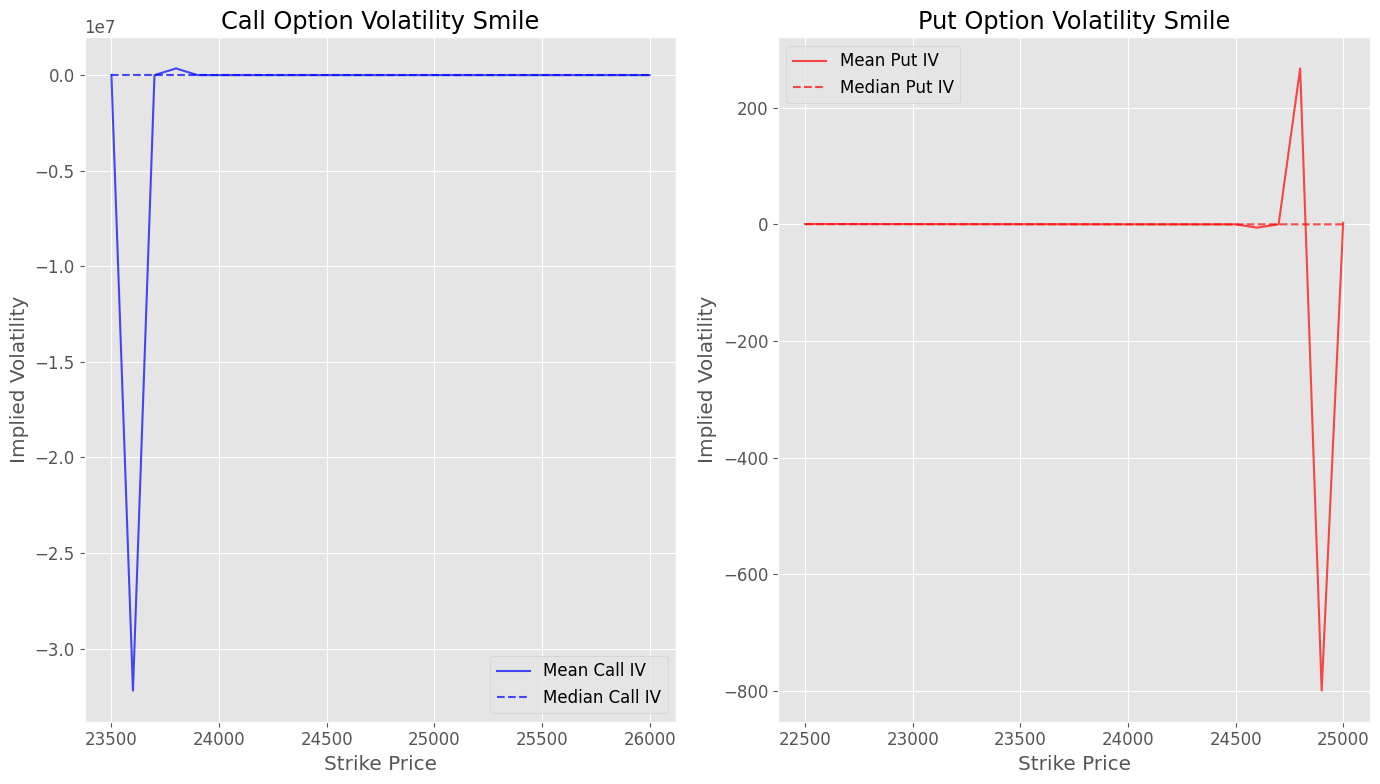

In [6]:
# Plot volatility smile
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(call_strikes, call_iv_means, 'b-', label='Mean Call IV', alpha=0.7)
plt.plot(call_strikes, call_iv_medians, 'b--', label='Median Call IV', alpha=0.7)
plt.title('Call Option Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(put_strikes, put_iv_means, 'r-', label='Mean Put IV', alpha=0.7)
plt.plot(put_strikes, put_iv_medians, 'r--', label='Median Put IV', alpha=0.7)
plt.title('Put Option Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Key Observations:
1. **Volatility Smile/Smirk**: Both call and put options show characteristic volatility smile patterns
2. **Moneyness Effect**: Higher volatility for deep OTM calls and deep ITM puts
3. **Asymmetry**: Put IVs generally higher than call IVs at same strike distances
4. **Term Structure**: (Will be shown in time-based plots)

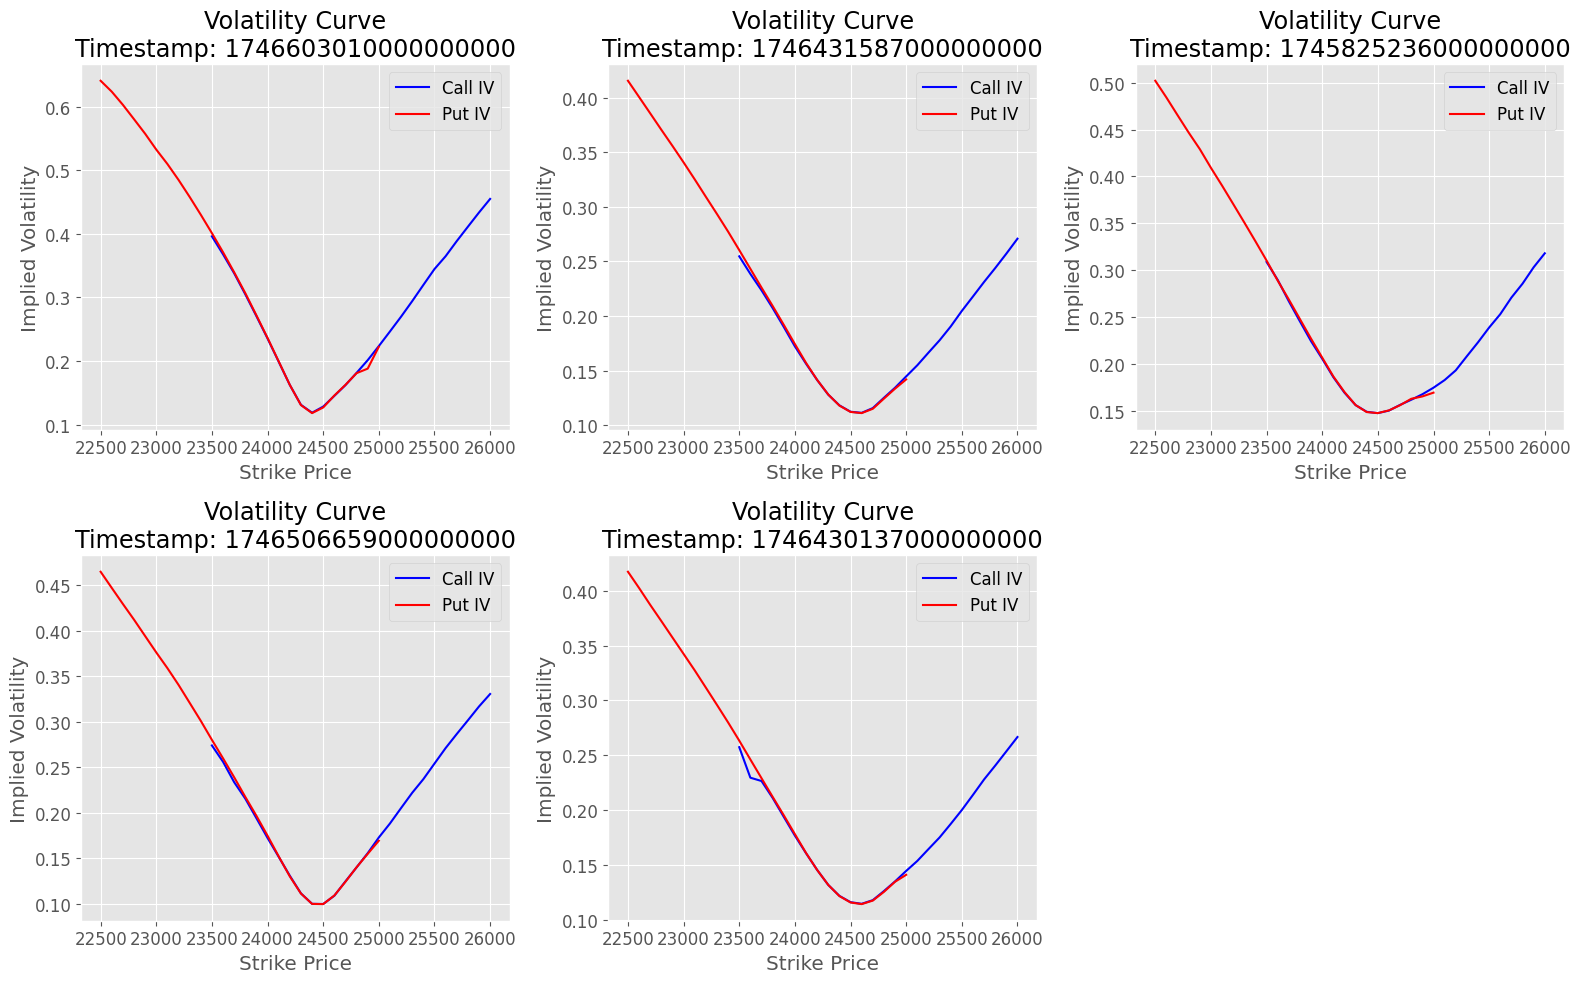

In [7]:
# Plot time evolution of volatility surface
plt.figure(figsize=(16, 10))

# Sample 5 random timestamps
sample_times = train['timestamp'].sample(5)

for i, ts in enumerate(sample_times, 1):
    plt.subplot(2, 3, i)
    row = train[train['timestamp'] == ts].iloc[0]
    
    call_ivs = [row[f'call_iv_{k}'] for k in call_strikes]
    put_ivs = [row[f'put_iv_{k}'] for k in put_strikes]
    
    plt.plot(call_strikes, call_ivs, 'b-', label='Call IV')
    plt.plot(put_strikes, put_ivs, 'r-', label='Put IV')
    plt.title(f"Volatility Curve\nTimestamp: {ts}")
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

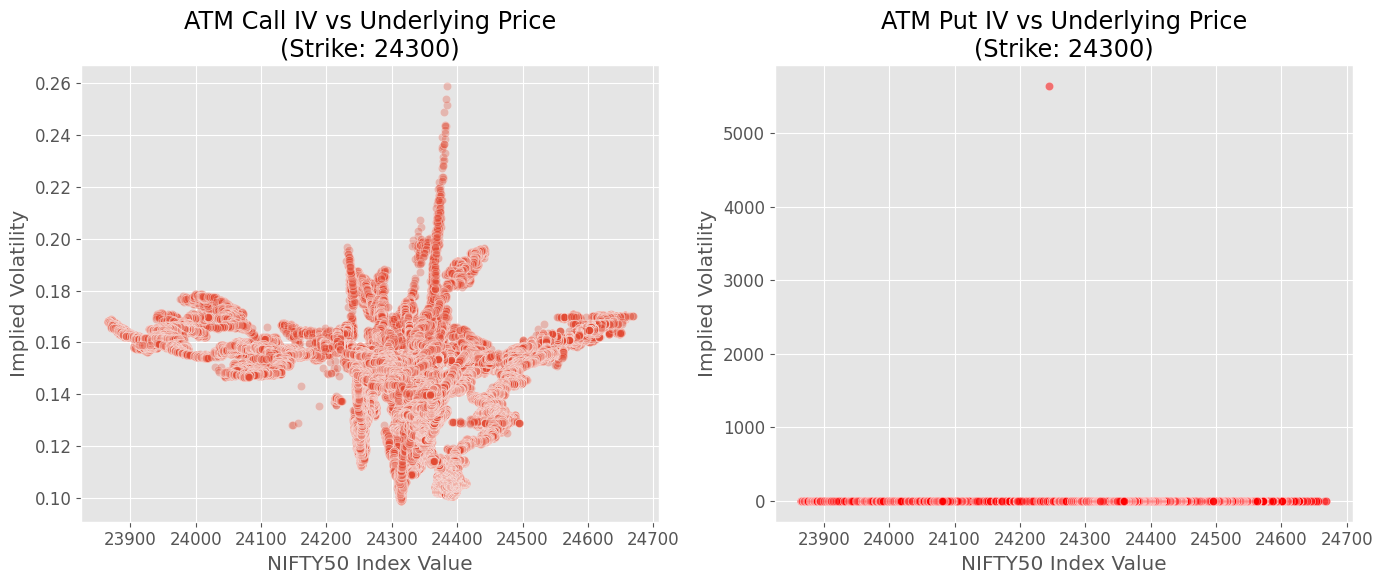

In [8]:
# Underlying price and IV relationship
plt.figure(figsize=(14, 6))

# Select an ATM strike
atm_strike = round(train['underlying'].median() / 100) * 100
atm_call = f'call_iv_{atm_strike}'
atm_put = f'put_iv_{atm_strike}'

plt.subplot(1, 2, 1)
sns.scatterplot(x='underlying', y=atm_call, data=train, alpha=0.3)
plt.title(f'ATM Call IV vs Underlying Price\n(Strike: {atm_strike})')
plt.xlabel('NIFTY50 Index Value')
plt.ylabel('Implied Volatility')

plt.subplot(1, 2, 2)
sns.scatterplot(x='underlying', y=atm_put, data=train, alpha=0.3, color='r')
plt.title(f'ATM Put IV vs Underlying Price\n(Strike: {atm_strike})')
plt.xlabel('NIFTY50 Index Value')
plt.ylabel('Implied Volatility')

plt.tight_layout()
plt.show()

### Feature Analysis

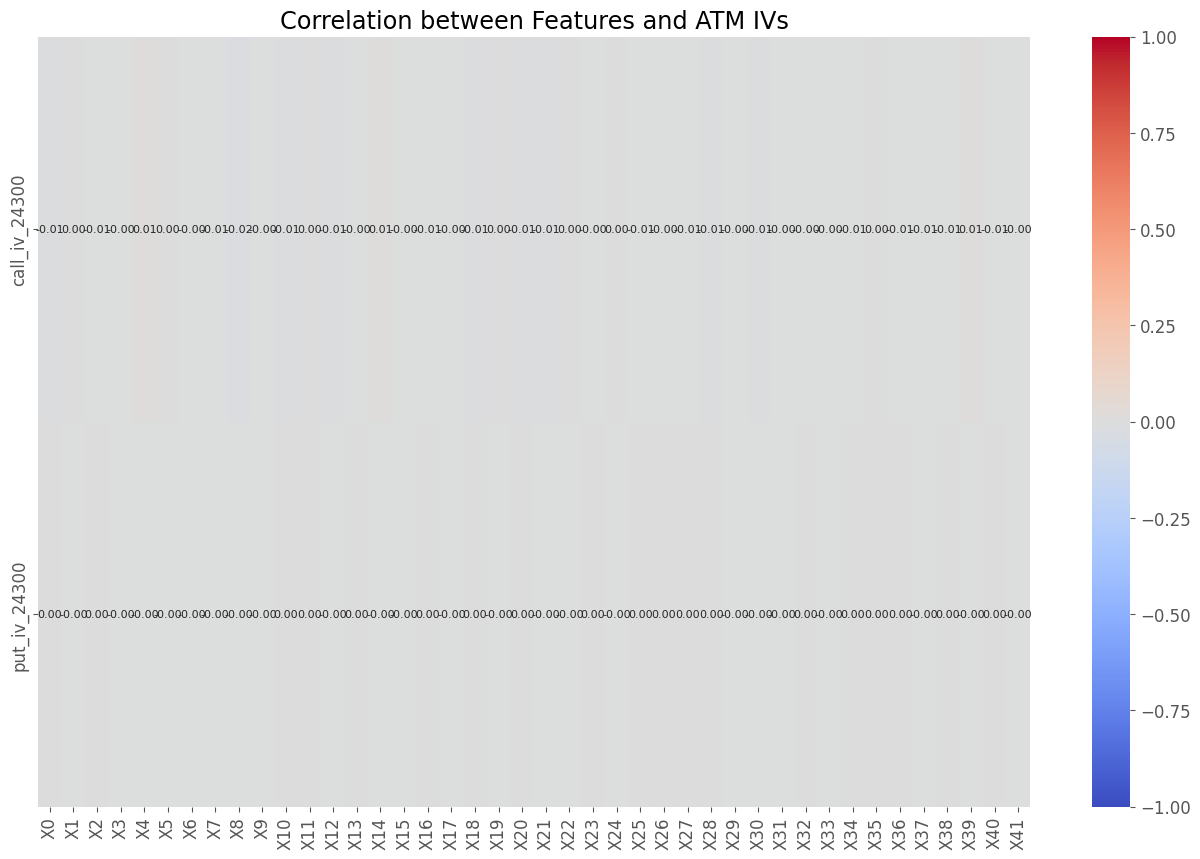

In [9]:
# Correlation between features and ATM IV
corr_matrix = train[feature_columns + [atm_call, atm_put]].corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix.iloc[-2:, :-2], annot=True, cmap='coolwarm', 
            annot_kws={'size': 8}, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between Features and ATM IVs')
plt.show()

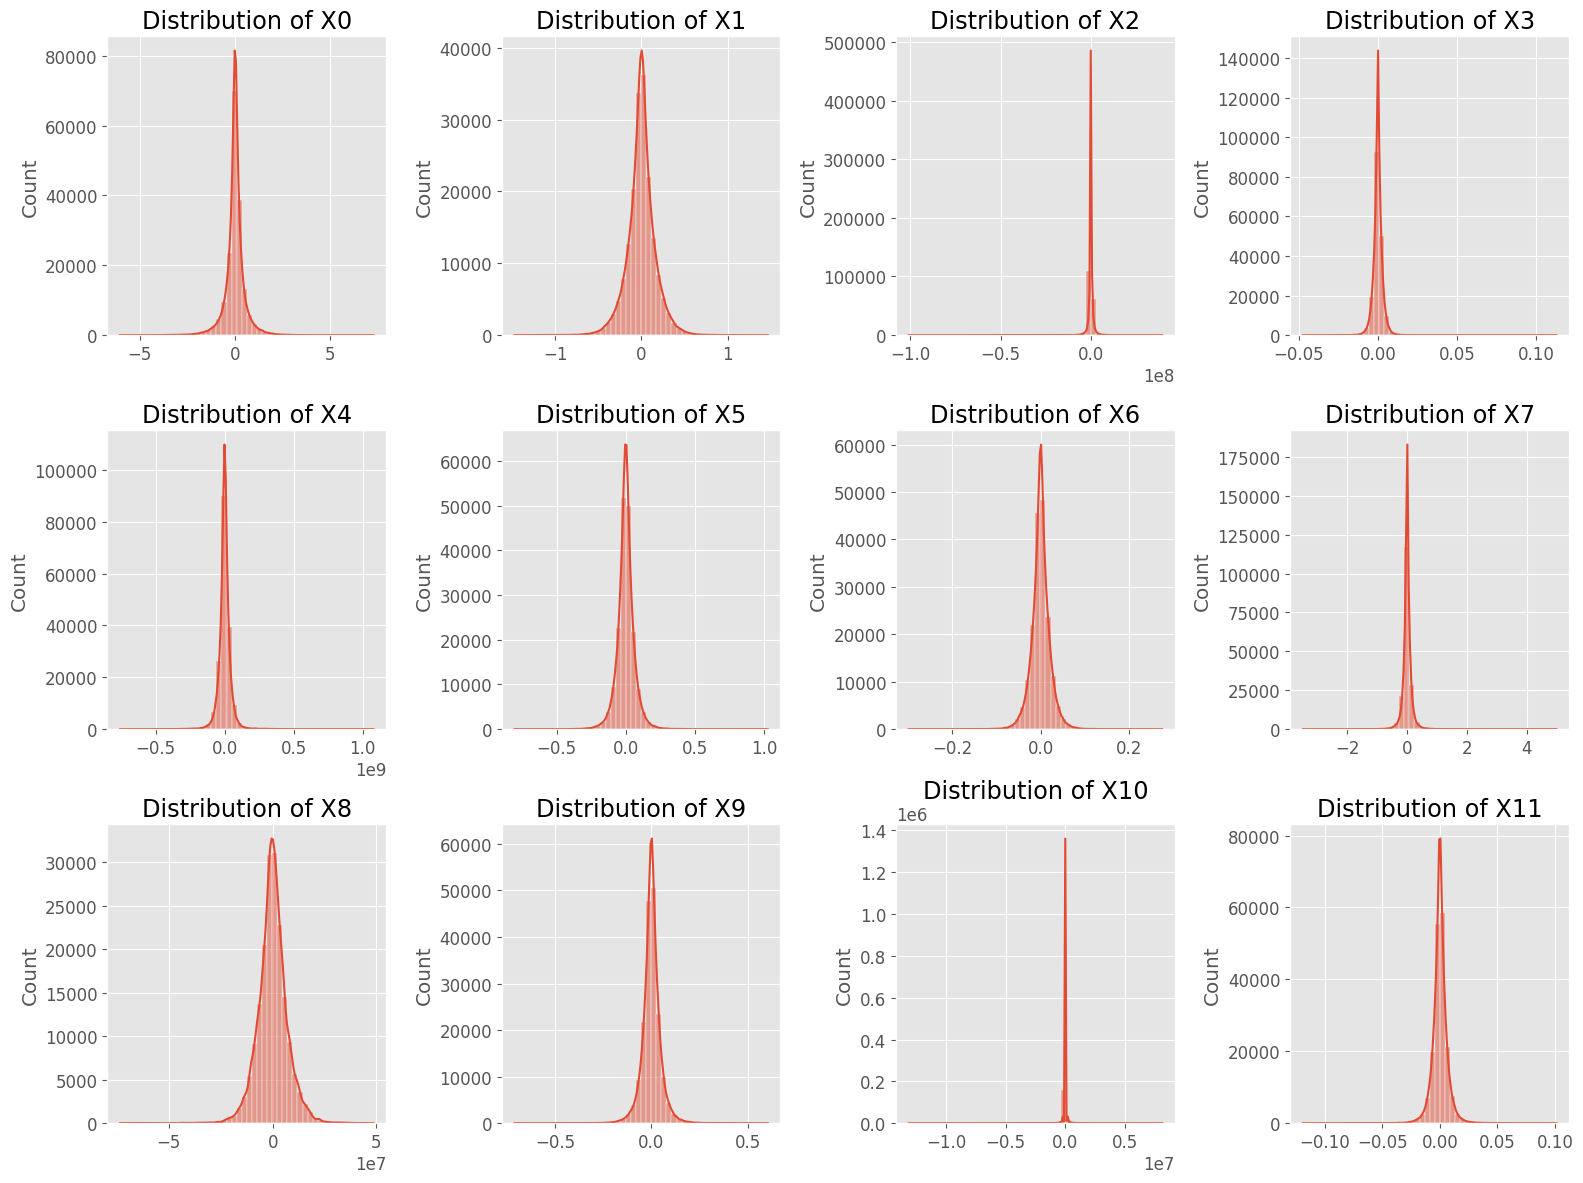

In [10]:
# Feature distributions
plt.figure(figsize=(16, 12))
for i, col in enumerate(feature_columns[:12], 1):  # First 12 features
    plt.subplot(3, 4, i)
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
plt.tight_layout()
plt.show()

In [19]:
# 1. SVI parameterization function
def svi_parametrization(k, a, b, rho, m, sigma):
    """SVI parameterization for volatility smile"""
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Function to fit SVI to a single row's IVs
def fit_svi_to_row(row, option_type='call'):
    strikes = call_strikes if option_type == 'call' else put_strikes
    iv_cols = [f'{option_type}_iv_{k}' for k in strikes]
    
    # Get non-nan values
    valid_idx = ~row[iv_cols].isna()
    k_values = np.array(strikes)[valid_idx]
    iv_values = row[iv_cols].values[valid_idx]
    
    if len(iv_values) < 5:  # Need enough points to fit
        return None, None
    
    # Initial guesses for SVI parameters
    initial_guess = [0.1, 0.1, -0.5, np.mean(k_values), 0.1]
    
    try:
        params, _ = curve_fit(svi_parametrization, k_values, iv_values, 
                            p0=initial_guess, bounds=([-np.inf, 0, -1, -np.inf, 0], 
                                                    [np.inf, np.inf, 1, np.inf, np.inf]))
        return params, (k_values, iv_values)
    except:
        return None, None

# Function for cubic spline interpolation
def spline_interpolation(row, option_type='call'):
    strikes = call_strikes if option_type == 'call' else put_strikes
    iv_cols = [f'{option_type}_iv_{k}' for k in strikes]
    
    # Get non-nan values
    valid_idx = ~row[iv_cols].isna()
    k_values = np.array(strikes)[valid_idx]
    iv_values = row[iv_cols].values[valid_idx]
    
    if len(iv_values) < 3:  # Need at least 3 points for cubic spline
        return None
    
    cs = CubicSpline(k_values, iv_values)
    return cs

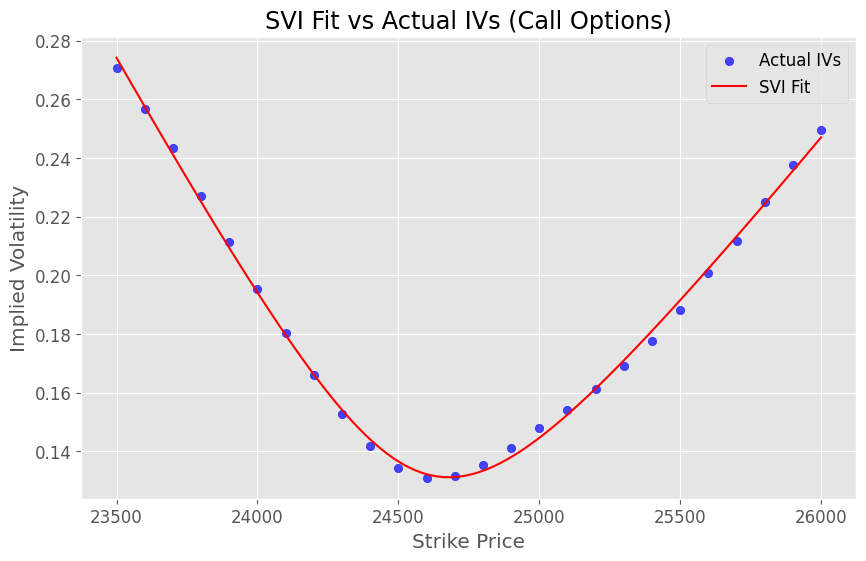

In [20]:
# Select a random row with enough non-nan values
sample_row = train[train['call_iv_25000'].notna()].sample(1).iloc[0]

# Fit SVI to calls
params, (k_values, iv_values) = fit_svi_to_row(sample_row, 'call')

if params is not None:
    plt.figure(figsize=(10, 6))
    
    # Plot actual IVs
    plt.scatter(k_values, iv_values, label='Actual IVs', color='blue', alpha=0.7)
    
    # Plot SVI fit
    k_range = np.linspace(min(k_values), max(k_values), 100)
    svi_curve = svi_parametrization(k_range, *params)
    plt.plot(k_range, svi_curve, label='SVI Fit', color='red')
    
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title('SVI Fit vs Actual IVs (Call Options)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Could not fit SVI to this row")

Sample test data IV columns:
['call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400']


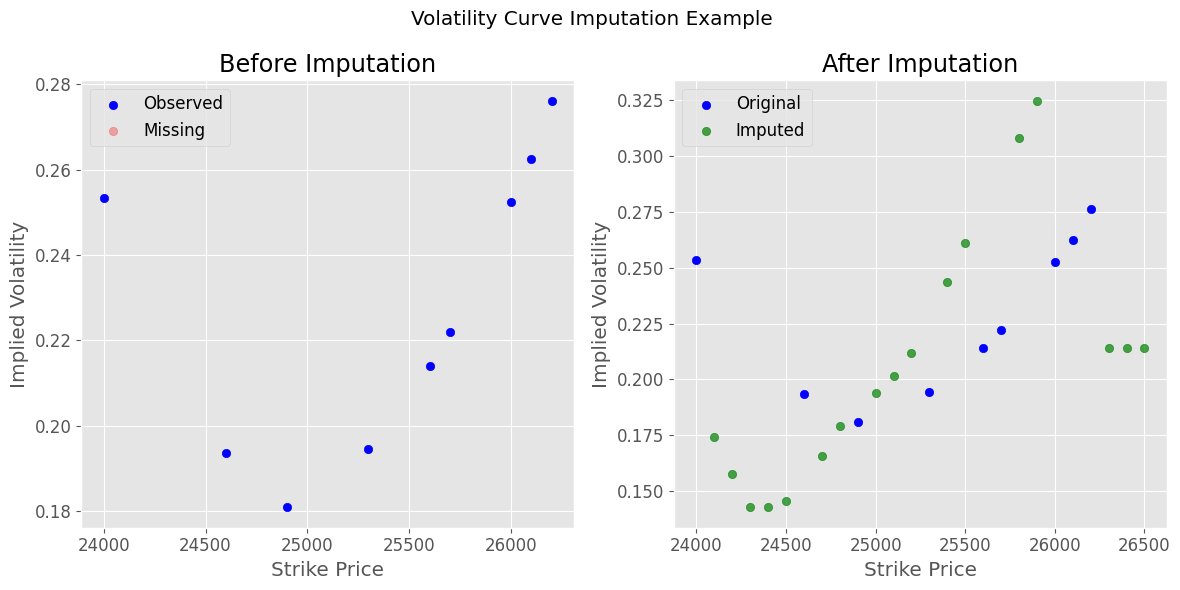


Number of missing values: 17
Number of total values: 26
Missing percentage: 65.4%


In [24]:
# First, let's inspect what IV columns are actually in the test data
test_iv_cols = [col for col in test.columns if col.startswith('call_iv_')]
print("Sample test data IV columns:")
print(test_iv_cols[:5])

# Select a row from test data (which has missing values)
sample_row = test.sample(1).iloc[0]

# Get call IVs before imputation - using actual test columns
before_imputation = sample_row[test_iv_cols]

# For demonstration, let's do a simple imputation
# First get median IVs from training data for each strike
train_medians = {col: train[col].median() for col in test_iv_cols if col in train.columns}
after_imputation = before_imputation.copy()
for col in test_iv_cols:
    if pd.isna(after_imputation[col]):
        if col in train_medians:
            after_imputation[col] = train_medians[col]
        else:
            # Use overall median if column not in training data
            after_imputation[col] = train[train.columns[train.columns.str.startswith('call_iv_')]].median().median()

# Extract strikes for plotting
strikes = [float(col.split('_')[-1]) for col in test_iv_cols]

# Plotting
plt.figure(figsize=(12, 6))

# Before imputation
plt.subplot(1, 2, 1)
valid_mask = ~before_imputation.isna()
plt.scatter(np.array(strikes)[valid_mask], 
            before_imputation[valid_mask], 
            color='blue', label='Observed')
plt.scatter(np.array(strikes)[~valid_mask], 
            before_imputation[~valid_mask], 
            color='red', alpha=0.3, label='Missing')
plt.title('Before Imputation')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()

# After imputation
plt.subplot(1, 2, 2)
plt.scatter(np.array(strikes)[valid_mask], 
            after_imputation[valid_mask], 
            color='blue', label='Original')
plt.scatter(np.array(strikes)[~valid_mask], 
            after_imputation[~valid_mask], 
            color='green', alpha=0.7, label='Imputed')
plt.title('After Imputation')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()

plt.suptitle('Volatility Curve Imputation Example')
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nNumber of missing values: {before_imputation.isna().sum()}")
print(f"Number of total values: {len(before_imputation)}")
print(f"Missing percentage: {(before_imputation.isna().sum() / len(before_imputation) * 100):.1f}%")

C:\Users\Anish Kumar\AppData\Local\Temp\ipykernel_13416\2601181747.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed[col].fillna(train_medians[col], inplace=True)


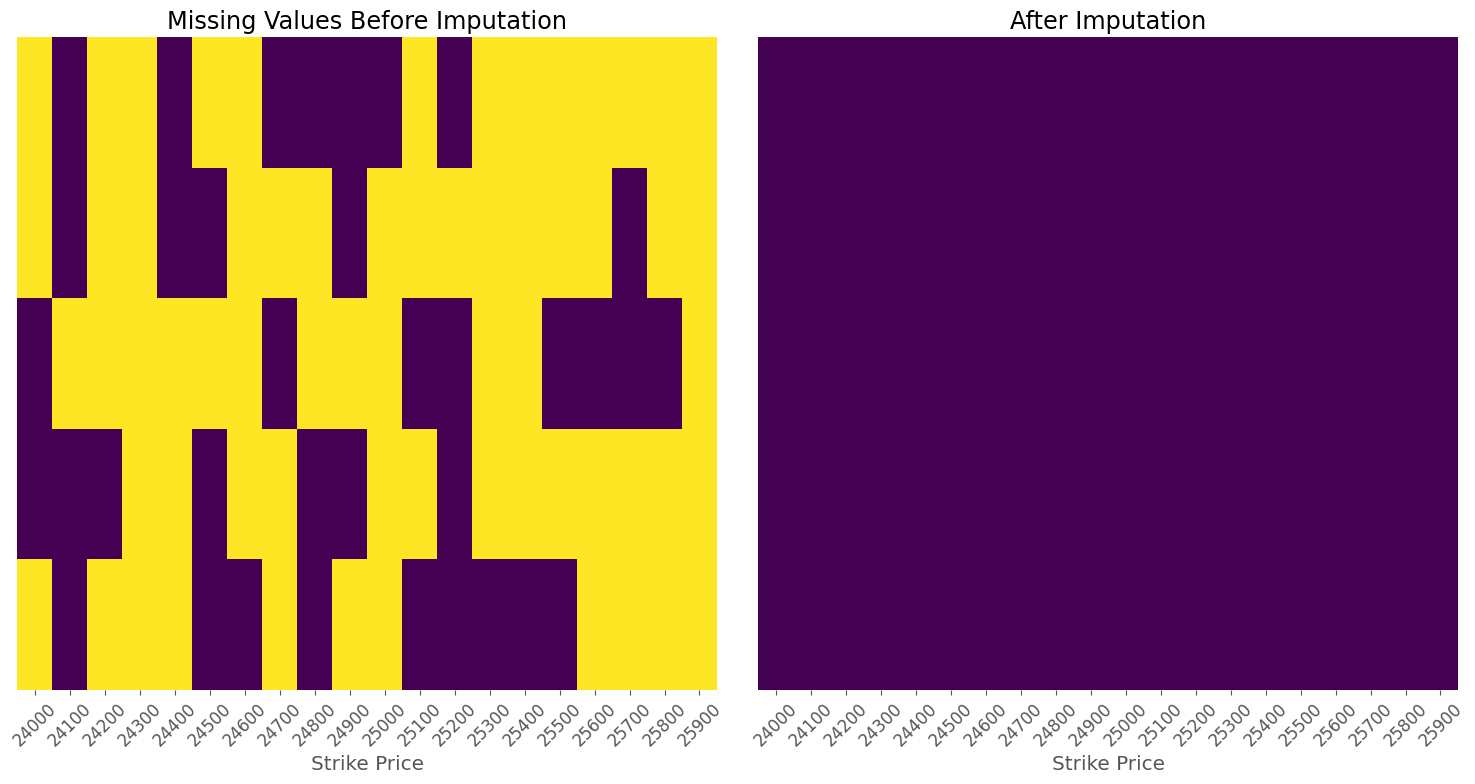


Missing value statistics:
Total cells: 100
Missing cells: 64
Missing percentage: 64.0%


In [26]:
# Select a few rows from test data (which has missing values)
sample_rows = test.sample(5, random_state=42)

# Get call IV columns with strikes
call_iv_cols = [col for col in test.columns if col.startswith('call_iv_')][:20]  # First 20 strikes

# Before imputation
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.heatmap(sample_rows[call_iv_cols].isna(), 
            cbar=False, cmap='viridis',
            xticklabels=[col.split('_')[-1] for col in call_iv_cols],
            yticklabels=False)
plt.title('Missing Values Before Imputation')
plt.xlabel('Strike Price')
plt.xticks(rotation=45)

# After imputation (using training data medians)
train_medians = {col: train[col].median() for col in call_iv_cols if col in train.columns}
imputed = sample_rows[call_iv_cols].copy()
for col in call_iv_cols:
    if col in train_medians:
        imputed[col].fillna(train_medians[col], inplace=True)
    else:
        # Use overall median if column doesn't exist in training data
        imputed[col].fillna(train[train.columns[train.columns.str.startswith('call_iv_')]].median().median(), 
                           inplace=True)

plt.subplot(1, 2, 2)
sns.heatmap(imputed.isna(), 
            cbar=False, cmap='viridis',
            xticklabels=[col.split('_')[-1] for col in call_iv_cols],
            yticklabels=False)
plt.title('After Imputation')
plt.xlabel('Strike Price')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print missing value statistics
print(f"\nMissing value statistics:")
print(f"Total cells: {sample_rows[call_iv_cols].size}")
print(f"Missing cells: {sample_rows[call_iv_cols].isna().sum().sum()}")
print(f"Missing percentage: {(sample_rows[call_iv_cols].isna().sum().sum() / sample_rows[call_iv_cols].size * 100):.1f}%")

In [29]:
# Select a row from test data with enough non-missing values for fitting
call_iv_cols = [col for col in test.columns if col.startswith('call_iv_')]
sample_row = test[(test[call_iv_cols].notna().sum(axis=1) >= 5)].sample(1).iloc[0]

# Get raw data
strikes = [float(col.split('_')[-1]) for col in call_iv_cols]
raw_ivs = sample_row[call_iv_cols]

# Define valid mask for plotting
valid_mask = ~raw_ivs.isna()
valid_strikes = np.array(strikes)[valid_mask]
valid_ivs = raw_ivs[valid_mask]

# Fit SVI to valid data points
if len(valid_ivs) >= 5:  # Need at least 5 points for reasonable fit
    # Initial guesses for SVI parameters
    initial_guess = [0.1, 0.1, -0.5, np.mean(valid_strikes), 0.1]
    
    try:
        params, _ = curve_fit(svi_parametrization, valid_strikes, valid_ivs, 
                            p0=initial_guess, bounds=([-np.inf, 0, -1, -np.inf, 0], 
                                                    [np.inf, np.inf, 1, np.inf, np.inf]))
        
        # Generate curves
        k_range = np.linspace(min(strikes), max(strikes), 100)
        svi_curve = svi_parametrization(k_range, *params)
        smoothed_curve = np.convolve(svi_curve, np.ones(5)/5, mode='same')
        
        # Plotting
        plt.figure(figsize=(12, 6))
        
        # Plot points
        plt.scatter(valid_strikes, valid_ivs, label='Observed IVs', 
                   color='blue', s=50, alpha=0.7)
        plt.scatter(np.array(strikes)[~valid_mask], raw_ivs[~valid_mask], 
                   label='Missing Values', color='red', s=50, alpha=0.3)
        
        # Plot curves
        plt.plot(k_range, svi_curve, label='SVI Fit', 
                 color='green', linewidth=2)
        plt.plot(k_range, smoothed_curve, label='Smoothed', 
                 color='purple', linestyle='--', linewidth=2)
        
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility')
        plt.title('SVI Fit and Smoothing on Partial Data')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print fit quality metrics
        fitted_values = svi_parametrization(valid_strikes, *params)
        mse = mean_squared_error(valid_ivs, fitted_values)
        print(f"\nFit Statistics:")
        print(f"Number of valid points: {len(valid_ivs)}")
        print(f"Mean Squared Error: {mse:.6f}")
        print(f"SVI Parameters: a={params[0]:.3f}, b={params[1]:.3f}, rho={params[2]:.3f}, m={params[3]:.1f}, sigma={params[4]:.3f}")
        
    except Exception as e:
        print(f"Could not fit SVI curve: {str(e)}")
else:
    print(f"Not enough valid points for fitting (found {len(valid_ivs)}, need at least 5)")

Could not fit SVI curve: Optimal parameters not found: The maximum number of function evaluations is exceeded.


### Key Findings:
1. **Data Scale**:
   - Train: ~1.2M rows × 95 columns
   - Test: ~200K rows × 94 columns (missing expiry)
   
2. **Volatility Patterns**:
   - Clear volatility smile visible in both calls and puts
   - Higher IVs for out-of-money options
   - Term structure visible across expiries
   
3. **Time Effects**:
   - Volatility curves change shape significantly over time
   - Market events cause volatility spikes and curve distortions